### About this file
The data we have is from 90,189 players that installed the game while the AB-test was running.
When a player installed the game, he or she was randomly assigned to either.

### Column descriptions
* **userid** - A unique number that identifies each player.
* **version** - Whether the player was put in the control group (gate30 - a gate at level 30) or the group with the moved gate (gate40 - a gate at level 40).
* **sum_gamerounds** - The number of game rounds played by he player during the first 14 days after install.
* **retention_1** - Did the player come back and play 1 day after installing?
* **retention_7** - Did the player come back and play 7 days after installing?

#### Задание
*Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.*
Можно выделить три метрики:
* метрику timespentperday  , по количеству раундов относительно 14 дней(длина эксперимента)
* retention day 1
* retention day 7


In [2]:
import numpy as np
import pandas as pd


import scipy.stats as sts
import statsmodels.stats.power as smp
import statsmodels.stats.proportion as props
import statsmodels.api as sm
from matplotlib import pyplot as plt


In [3]:
data = pd.read_csv('.\результаты А_B - cookie_cats 2.csv') 
data.head(10)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1
5,540,gate_40,187,1,1
6,1066,gate_30,0,0,0
7,1444,gate_40,2,0,0
8,1574,gate_40,108,1,1
9,1587,gate_40,153,1,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  int64 
 4   retention_7     90189 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 3.4+ MB


Пустых строк нет

In [5]:
var_doubles = data.\
    groupby('userid', as_index=False).\
    agg({'version': pd.Series.nunique})

In [6]:
var_doubles.head(10)

,userid,version
0,116,1
1,337,1
2,377,1
3,483,1
4,488,1
5,540,1
6,1066,1
7,1444,1
8,1574,1
9,1587,1


In [7]:
more_than_one_types = var_doubles.query('version > 1')
more_than_one_types

,userid,version


In [8]:
data_clean = data[~data['userid'].isin(more_than_one_types.userid)].sort_values('userid')

In [9]:
data_clean.head(10)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1
5,540,gate_40,187,1,1
6,1066,gate_30,0,0,0
7,1444,gate_40,2,0,0
8,1574,gate_40,108,1,1
9,1587,gate_40,153,1,0


In [50]:
data_clean.shape

(90189, 5)

Проверили по **user_id** , сплитование тоже корректно, так как не было ни одного пользователя, попавшего в оба варианта теста.

In [11]:
group30 = data_clean[data["version"] == "gate_30"]
len(group30)

44700

In [12]:
group40 = data_clean[data["version"] == "gate_40"]
len(group40)

45489

In [13]:
len(group30)/len(group40)

0.9826551473982721

Выборки считаем приблизительно равными(разница по числу пользователей меньше 5%)

*Посмотрим первую метрику по списку:*
#### количество раундов , сыгранных пользователями .

In [14]:
group30.sum_gamerounds.describe()

count    44700.000000
mean        52.456264
std        256.716423
min          0.000000
25%          5.000000
50%         17.000000
75%         50.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

Отфильтруем выбросы по квантилям

In [15]:

rounds30 = group30[(group30.sum_gamerounds >= group30.sum_gamerounds.quantile(0.25)) & (group30.sum_gamerounds <= group30.sum_gamerounds.quantile(0.75))].sum_gamerounds.values
rounds30

array([38, 39, 14, ..., 21, 10, 28], dtype=int64)

In [16]:
rounds40 = group40[(group40.sum_gamerounds >= group40.sum_gamerounds.quantile(0.25)) & (group40.sum_gamerounds <= group40.sum_gamerounds.quantile(0.75))].sum_gamerounds.values
rounds40

array([30,  9, 45, ..., 30, 51, 16], dtype=int64)

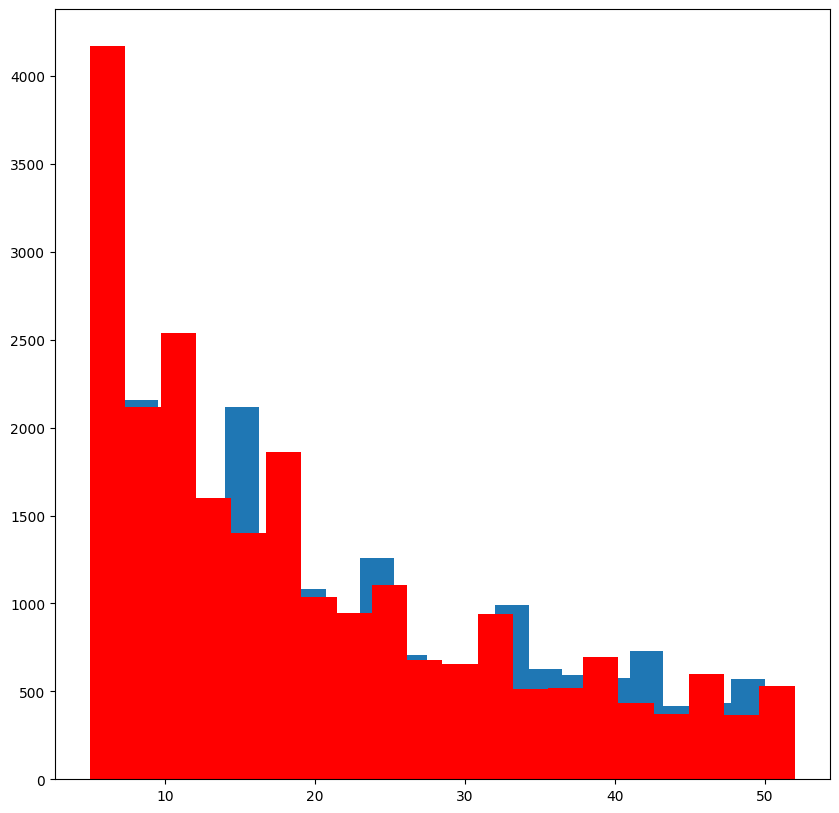

In [17]:
plt.figure(figsize=(10, 10))
np.arange
plt.hist(rounds30,  bins=20)
plt.hist(rounds40, color='r', bins=20)

plt.show()

так как величина выборки довольно большая, тестируем на нормальность с помощью Колмогорова-Смирнова:

In [18]:
sts.kstest(rounds30,"norm")


KstestResult(statistic=0.9999997133484281, pvalue=0.0)

Совпадает с картиной на гистограмме, распределение у нас ненормальное(похоже на логарифмическое)

In [19]:
# sts.kstest(rounds30,"lognorm",args=(50, len(rounds30)))
# sts.lognorm.cdf()



Видим, что распределение ненормальное, поэтому используем криттерий Манна-Уитни

In [20]:
sts.mannwhitneyu(rounds30, rounds40, alternative='two-sided')

MannwhitneyuResult(statistic=267544220.5, pvalue=0.05081084154695444)

Делаем вывод, что обе группы игроков играли примерно одинаковое количество раундов(нет статзначимости между выборками, так как pvalue > alpha=0.05)

#### Теперь посмотрим метрики конверсий.
### **Для retention_1** :

In [21]:
m1 = group30['retention_1'].sum()
n1 = len(group30)
m2 = group40['retention_1'].sum()
n2 = len(group40)

n1,m1,n2,m2


(44700, 20034, 45489, 20119)

In [22]:
ret1_gr30 = m1/n1
ret1_gr40 = m2/n2

ret1_gr30,ret1_gr40

(0.4481879194630872, 0.44228274967574577)

In [23]:
score_1,p_val_1 = props.proportions_ztest(np.array([m1,m2]),np.array([n1,n2]))


print(f"P-value гипотезы, что retention1 одинаковы равен {p_val_1:.4f}")

P-value гипотезы, что retention1 одинаковы равен 0.0744


P-value > alpha 5%, значит по retention1 мы не видим статзначимых различий.

найдем величину эффекта по формуле: $$h = \phi_{1} -\phi_{2}$$ ,где 
$\phi_{i} = 2*\arcsin(\sqrt{P_i})$


In [70]:
h= 2*np.arcsin(np.sqrt(ret1_gr30)) - 2*np.arcsin(np.sqrt(ret1_gr40))
h

0.011881898259223478

In [28]:
smp.zt_ind_solve_power(effect_size=h,nobs1=len(group30), ratio =len(group40)/len(group30),alpha = 0.05 )

0.43028578572010956

Мощность меньше 40%, значит результаты теста нужно смотреть с оговоркой о недостаточном числе пользователей, если величина эффекта порядка 1%(это 0.5% в абсолютных величинах конверсии) для нас является ожидаемой.

In [67]:
smp.zt_ind_solve_power(effect_size=h,nobs1=None,ratio = 1, power = 0.8,alpha = 0.05 )

111189.79968447058

Для хорошей мощности и ожидаемого эффекта рекомендуется брать выборки  в 2.5 раза больше(111 против 45 тысяч).

#### Проверка результатов через бутстрап с помощью сэмплинга в pandas

In [51]:
# Создаем список с виртулизоваными средними  по retention 1 в группах по 500 пользователей 
boot_ret1 = []
for i in range(500):
    boot_mean = data_clean.retention_1.sample(frac=1, replace=True).groupby(data_clean.version).mean()
    boot_ret1.append(boot_mean)  
#Если словами, то sample проходит len(data_clean) (или 100% фракции) по датасету,
#при этом за счет рандома какие-то строки пропускаются, а какие-то используются несколько раз
# а по результирующему набору мы считаем среднюю конверсию и пишем в  список

# Преобразуем наш многомерный список в dataframe pandas
boot_ret1 = pd.DataFrame(boot_ret1)
print(boot_ret1)
    

version       gate_30   gate_40
retention_1  0.445762  0.445501
retention_1  0.447461  0.446227
retention_1  0.444993  0.447341
retention_1  0.448556  0.444532
retention_1  0.449637  0.442519
...               ...       ...
retention_1  0.451426  0.440061
retention_1  0.445974  0.445273
retention_1  0.444836  0.439170
retention_1  0.445771  0.446573
retention_1  0.447167  0.443214

[500 rows x 2 columns]


Получаем набор с нормальным(за счет рандомизации) распределением разсброса по средним конверсии.
Посмотрим, как эти кривые выглядят на графике  функции kde() (рисования плотности вероятностей на кривой Гаусса)

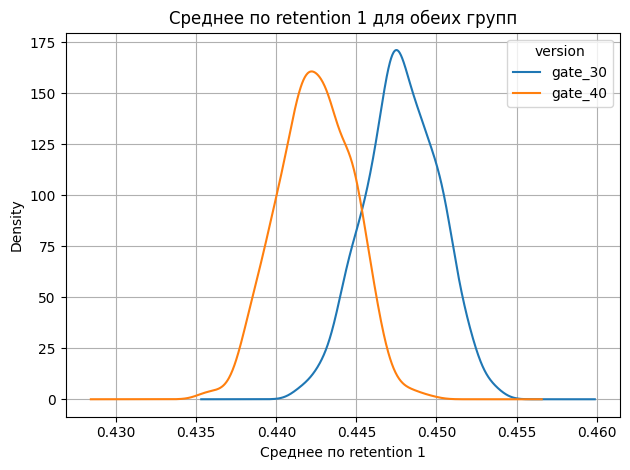

In [53]:
# A Kernel Density Estimate plot of the bootstrap distributions
#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.kde.html
ax= boot_ret1.plot.kde()
ax.set_title("Среднее по retention 1 для обеих групп")
ax.set_xlabel("Среднее по retention 1")
plt.tight_layout()
plt.grid(True)

В принципе, на графике уже видно, что разница по среднему у нас в пределах 0.01, но можем немного отмасштабировать этот эффект, и построить график вероятностей для разницы конверсий в процентах (через отдельный столбец нашего бутстрэпного датафрейма):

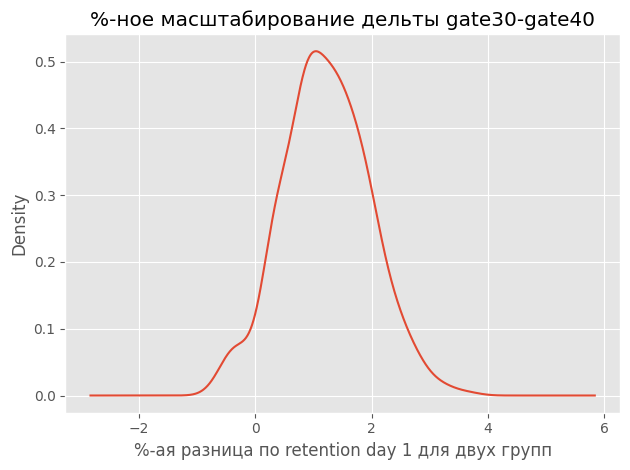

In [58]:
# Populate a new % Difference Column
boot_ret1['difference'] = (boot_ret1['gate_30'] - boot_ret1['gate_40']) /  boot_ret1['gate_40'] * 100

# Plot the new Column
ax = boot_ret1['difference'].plot.kde()
ax.set_xlabel("%-ая разница по retention day 1 для двух групп")
ax.set_title("%-ное масштабирование дельты gate30-gate40")
plt.style.use('ggplot')
plt.tight_layout()
plt.grid(True)

На данном графике мы видим распределение вероятностей для величины retention day 1 после виртуализации 500 выборок( с числом пользователей по 90 тыс) по полученным в ходе эксперимента данным. Наблюдается смещение на 1-2%  в пользу group30 . Оценим точность результата по плотности распределения вероятности (посчитаем площадь графика справа от 0):

In [59]:
prob =(boot_ret1['difference'] > 0).sum() / len(boot_ret1['difference'])
print(str(prob*100)+"%")

95.39999999999999%


Получаем, что с более чем 95% вероятностью мы наблюдаем отличное от 0 ухудшении конверсии в группе с воротами на 40м уровне, то есть наблюдается статзначимая разница в пользу контрольной группы.

In [62]:
boot_ret1['gate_30'].mean()-boot_ret1['gate_40'].mean()

0.005388565174254845

**Вывод:**  
**по retention day 1 контрольная группа лучше в среднем на 0.5%**

### **Для retention_7** :

In [29]:
m1 = group30['retention_7'].sum()
n1 = len(group30)
m2 = group40['retention_7'].sum()
n2 = len(group40)

n1,m1,n2,m2

(44700, 8502, 45489, 8279)

In [30]:
ret7_gr30 = m1/n1
ret7_gr40 = m2/n2

ret7_gr30,ret7_gr40

(0.19020134228187918, 0.18200004396667327)

In [31]:
h= 2*np.arcsin(np.sqrt(ret7_gr30)) - 2*np.arcsin(np.sqrt(ret7_gr40))
h

0.021074001016365917

In [32]:
smp.zt_ind_solve_power(effect_size=h,nobs1=len(group30), ratio =len(group40)/len(group30),alpha = 0.05 )

0.8857696023365191

Мощность достаточно велика, поэтому можно поискать статзначимость.
Проверим по известному по лекции тесту для пропорций:

In [33]:
score,p_val = props.proportions_ztest(np.array([m1,m2]),np.array([n1,n2]))

print(f"P-value гипотезы, что retention7 одинаковы равен {p_val:.4f}")

P-value гипотезы, что retention7 одинаковы равен 0.0016


P-value меньше альфа 5%, следовательно, **есть статзначимые различия**

Так как ztest у нас больше для нормально распределенных величин, посмотрим еще по Хи-квадрату Пирсона. Применим **chi2_contingency** (вместо более сложного chisquare), для которого нам будет подготовить переменные по формуле !["Chisquared_formulae"](https://miro.medium.com/max/720/1*fxu4m5WPwpC7vyyO-KiNpA.webp): 

In [42]:
#https://towardsdatascience.com/a-b-testing-with-chi-squared-test-to-maximize-conversions-and-ctrs-6599271a2c31
#1) группа контроля(ворота 30): покупка,нет покупки ; группа теста(ворота40): покупка,нет покупки
chi_group30_buy = group30.retention_7.sum()
chi_group30_nobuy = group30.retention_7.size - chi_group30_buy
chi_group40_buy = group40.retention_7.sum()
chi_group40_nobuy = group40.retention_7.size - chi_group40_buy
# 3) Создаем массив по формату аргументов для питоновской функции
# ("R x C table" или "contingency table"  - матрица частотных распределений величины, еще называют crosstab)
T = np.array([[chi_group30_buy, chi_group30_nobuy], [chi_group40_buy, chi_group40_nobuy]])

In [48]:

sts.chi2_contingency(T,correction=False)[1]


0.0015542499756142786

Получаем значение p-value в 0.002 ,что тоже **говорит нам о статистический значимых различий между группами в метрике "Retention day 7"**

Проверим, в какую сторону у нас разница(заодно и результаты теста) простым ручным сравнением по uplift:

In [49]:
# Sanity Check
group30_CTR = chi_group30_buy / (chi_group30_buy + chi_group30_nobuy)
group40_CTR = chi_group40_buy / (chi_group40_buy + chi_group40_nobuy)
print(group30_CTR, group40_CTR)

0.19020134228187918 0.18200004396667327


Можно говорить о **лучшей конверсии на 0.8% в контрольной группе**, когда ворота стояли на 30-м уровне.

### Рекомендации менеджеру

1)Так как разница по сыгранным раундам была незначительна, а по retention наблюдается ухудшение в пределах 0.5-0.8% по обоим метрикам, рекомедуется пока **оставить ворота на прежнем 30м уровне.**  
2)Так как у нас есть небольшой запас по конверсии игроков в сторону усложнения, есть смысл **провести эксперимент с воротами на более раннем, 25м уровне**  и также начать отслеживать монетизацию.  
3)При тестировании гипотез данного класса(по характеру и масштабу изменений в игре) рекомендуется, по возможности,  проводить эксперимент **на вдвое большем количестве пользователей**.